# Best Models Comparison

Input: single principal component with PCA for 15 indicators + returns

Output: optimal max-shape portfolio with tight restrictions for the next period

In [1]:
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv1D, Dropout, Bidirectional, GRU
from keras.regularizers import L2

from sklearn.ensemble import RandomForestRegressor

from helper_functions import train_and_evaluate_model, run_full_backtesting

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()
y = data_provider.get_formatted_targets()

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Selected best performing models

In [4]:
x_7_months_flatten = data_provider.get_formatted_features(no_months=7, flatten=True)
(x_train_7_months_flatten, y_train, x_val_7_months_flatten, y_val, 
 x_test_7_months_flatten, y_test) = data_provider.train_train_split(x_7_months_flatten, y)

In [5]:
dnn_model = Sequential((
    Input(shape=x_train_7_months_flatten.shape[1:]),
    Dense(64, activation='relu', kernel_regularizer=L2(0.3)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(dnn_model, x_train_7_months_flatten, y_train,
                         x_val_7_months_flatten, y_val, 
                         x_test_7_months_flatten, y_test, verbose=False)

Train error: 0.0004816624859813601
Val error: 0.0006580828921869397
Test error: 0.0010086932452395558
Execution time 4.73 seconds


In [6]:
x_7_months = data_provider.get_formatted_features(no_months=7)
(x_train_7_months, y_train, x_val_7_months, y_val, 
 x_test_7_months, y_test) = data_provider.train_train_split(x_7_months, y)

In [7]:
cnn_model = Sequential((
    Input(shape=x_train_7_months.shape[1:]),
    Conv1D(32, 3),
    Flatten(),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(cnn_model, x_train_7_months, y_train,
                         x_val_7_months, y_val, 
                         x_test_7_months, y_test, verbose=False)

Train error: 0.0004996786010451615
Val error: 0.0006578403408639133
Test error: 0.0010458992328494787
Execution time 4.87 seconds


In [8]:
x_9_months_flatten = data_provider.get_formatted_features(no_months=9, flatten=True)
(x_train_9_months_flatten, y_train, _, _,
 x_test_9_months_flatten, y_test) = data_provider.train_train_split(x_9_months_flatten, y, with_val=False)

In [9]:
random_forest = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                                      min_samples_split=6, n_estimators=50, random_state=42)

random_forest.fit(x_train_9_months_flatten, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=50, random_state=42)

## Backtesting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


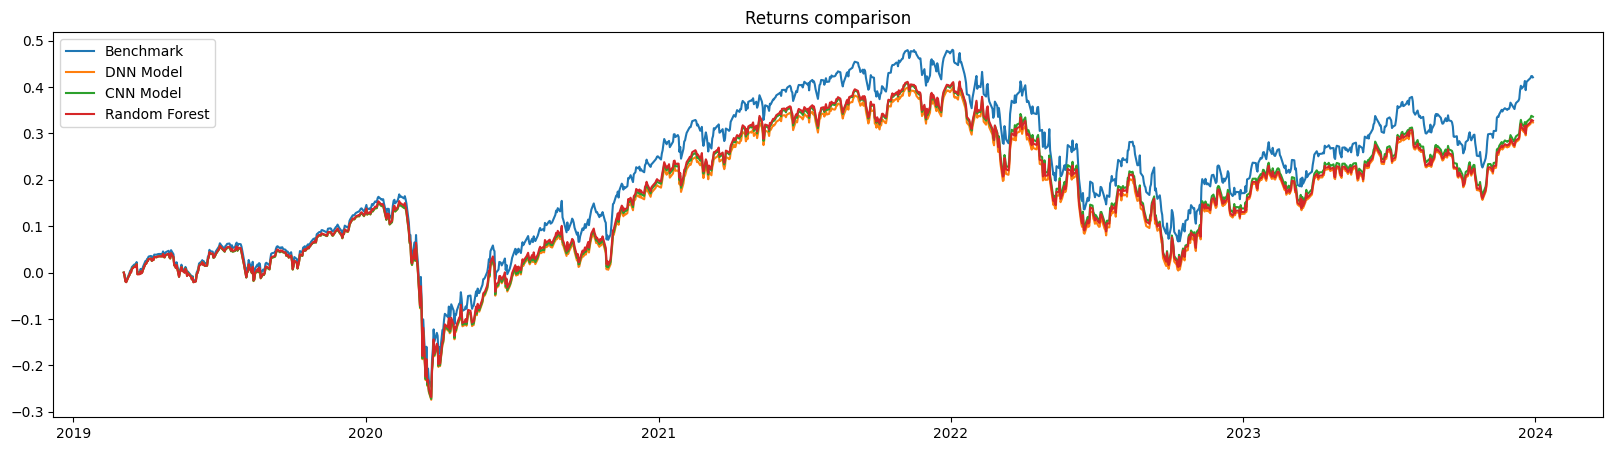

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
DNN Model,0.060565,0.201738,0.300216,0.347383,-0.368924,493.0,0.164166,-0.593036
CNN Model,0.062608,0.201344,0.310952,0.360298,-0.367342,538.0,0.170436,-0.524618
Random Forest,0.061191,0.202204,0.302619,0.351923,-0.366006,493.0,0.167185,-0.599576


In [10]:
models_with_data = {
    'DNN Model': (dnn_model, x_test_7_months_flatten),
    'CNN Model': (cnn_model, x_test_7_months),
    'Random Forest': (random_forest, x_test_9_months_flatten)
}

df_results = run_full_backtesting(data_provider, models_with_data)
df_results